# 0. Import libraries

The libraries used to create the data are in the following cell

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LearningRateScheduler,TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 1. Define constants

This section defines constants to be used in the notebook

In [2]:
# Path constants
DATA_FOLDER_PATH = "./Data"
FEATURES_FILENAME = "surfaces.npy"
LABELS_FILENAME = "coefficients.npy"

FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{FEATURES_FILENAME}"
LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LABELS_FILENAME}"

# Column names
SURFACE_POINTS = "surface_points"
ZERNIKE_COEFFICIENTS = "zernike_coefficients"

# Neural network architecture size
INPUT_SIZE = 60
OUTPUT_SIZE = 21

# Neural network training parameters
N_EPOCHS = 5000
BATCH_SIZE = 512
LEARNING_RATE = 0.01
ACTIVATION = 'relu'
N_HIDDEN = [512, 256, 64]
REGULARIZER = keras.regularizers.L1L2(l1=0.001,l2=0.1)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = tf.keras.metrics.MeanSquaredError()

2023-09-23 11:11:18.842303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:11:18.860866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-23 11:11:18.861049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 2. Compile functions

In [3]:
def get_features_and_labels_from_df(df):
    """
    Converts the columns of a surface dataframe into a list of features and labels in the form of list of numpy arrays
    Input:
        df (pd.DataFrame): The surface dataframe with columns 'surface_points'(features) and 'zernike_coefficients'(labels)
    
    Output:
        features (np.array): A numpy array with the z values of the surface at sampled points
        labels (np.array): A numpy array with the Zernike coefficients of the surface
    """
    features = convert_column_into_numpy_array_list(df, SURFACE_POINTS)
    labels = convert_column_into_numpy_array_list(df, ZERNIKE_COEFFICIENTS)
    return features, labels
    

def convert_column_into_numpy_array_list(df, column_name):
    """
    Converts the specified column of the dataframe into a list of numpy arrays
    Input:
        df (pd.DataFrame): The surface dataframe with columns 'surface_points' and 'zernike_coefficients'
        column_name (string): The name of the column to convert to list of numpy arrays
        
    Returns:
        numpy_list (tensor): The list of numpy arrays converted from the column
    """
    numpy_series = df[column_name].apply(lambda x: np.fromstring(x[1: -1], dtype=float, sep=' ')).to_list()
    numpy_list = tf.data.Dataset.from_tensor_slices(numpy_series)
    return numpy_series


def create_architecture():
    model = keras.Sequential(name="SurfaceReconstructor")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="linear"
                                ))
    
    model_name = "SurfaceReconstructor"
    return model, model_name


def compile_model(my_model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=[METRICS])
    

# 2. Read data

First read the data

In [4]:
features = np.load(FEATURES_FILE_PATH, allow_pickle=True)
labels = np.load(LABELS_FILE_PATH, allow_pickle=True)

Split the data:
- **80%** training
- **10%** validation/dev test
- **10%** final test

In [5]:
# Calculate the number of rows for each split
total_rows = len(features)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)

# Split the DataFrame into training (80%), validation (10%), and test (10%)
train_features = features[:train_size]
train_labels = labels[:train_size]

val_features = features[train_size:train_size + val_size]
val_labels = labels[train_size:train_size + val_size]

test_features = features[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# 3. Train neural network

Create the neural network architecture and compile it

In [6]:
surface_reconstruction_model, model_name = create_architecture()
compile_model(surface_reconstruction_model)

Define the callbacks

In [7]:
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1)
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1)
callbacks = [reduce_lr, early_stop]

In [8]:
history = surface_reconstruction_model.fit(train_features,
                                           train_labels,
                                           batch_size=BATCH_SIZE,
                                           epochs=N_EPOCHS,
                                           validation_data= (val_features, val_labels),
                                           callbacks=callbacks,
                                           verbose=1)

Epoch 1/5000


2023-09-23 11:11:21.077073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-23 11:11:21.080943: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fccc0026590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-23 11:11:21.080987: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-23 11:11:21.090340: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-23 11:11:21.227479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-23 11:11:21.326083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

94/94 [==============================] - 3s 8ms/step - loss: 27.9191 - mean_squared_error: 8.6493 - val_loss: 16.4696 - val_mean_squared_error: 13.4165 - lr: 0.0100
Epoch 2/5000
94/94 [==============================] - 1s 7ms/step - loss: 6.4022 - mean_squared_error: 3.6261 - val_loss: 11.9587 - val_mean_squared_error: 9.7884 - lr: 0.0100
Epoch 3/5000
94/94 [==============================] - 1s 7ms/step - loss: 5.2223 - mean_squared_error: 3.2020 - val_loss: 7.5607 - val_mean_squared_error: 5.7955 - lr: 0.0100
Epoch 4/5000
94/94 [==============================] - 1s 6ms/step - loss: 4.4752 - mean_squared_error: 2.9255 - val_loss: 5.6219 - val_mean_squared_error: 4.1860 - lr: 0.0100
Epoch 5/5000
94/94 [==============================] - 1s 7ms/step - loss: 3.9925 - mean_squared_error: 2.7185 - val_loss: 5.6997 - val_mean_squared_error: 4.5987 - lr: 0.0100
Epoch 6/5000
94/94 [==============================] - 1s 7ms/step - loss: 3.7057 - mean_squared_error: 2.6255 - val_loss: 5.3107 - val

Epoch 48/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.4725 - mean_squared_error: 1.9869 - val_loss: 7.1710 - val_mean_squared_error: 6.6760 - lr: 0.0100
Epoch 49/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.4414 - mean_squared_error: 1.9769 - val_loss: 5.0020 - val_mean_squared_error: 4.5395 - lr: 0.0100
Epoch 50/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.5023 - mean_squared_error: 2.0036 - val_loss: 5.6188 - val_mean_squared_error: 5.1467 - lr: 0.0100
Epoch 51/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.4755 - mean_squared_error: 1.9963 - val_loss: 13.9223 - val_mean_squared_error: 13.4255 - lr: 0.0100
Epoch 52/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.4710 - mean_squared_error: 1.9829 - val_loss: 6.1090 - val_mean_squared_error: 5.6393 - lr: 0.0100
Epoch 53/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.5152 - mean_squared_error: 2.0211 - val_l

94/94 [==============================] - 0s 5ms/step - loss: 2.4774 - mean_squared_error: 1.9605 - val_loss: 23.0525 - val_mean_squared_error: 22.5592 - lr: 0.0100
Epoch 95/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.4637 - mean_squared_error: 1.9560 - val_loss: 10.3148 - val_mean_squared_error: 9.8216 - lr: 0.0100
Epoch 96/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.4612 - mean_squared_error: 1.9570 - val_loss: 10.0753 - val_mean_squared_error: 9.5751 - lr: 0.0100
Epoch 97/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.4538 - mean_squared_error: 1.9480 - val_loss: 22.4429 - val_mean_squared_error: 21.9423 - lr: 0.0100
Epoch 98/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.4818 - mean_squared_error: 1.9678 - val_loss: 70.0835 - val_mean_squared_error: 69.4897 - lr: 0.0100
Epoch 99/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.4476 - mean_squared_error: 1.9405 - val_loss: 9.9

Epoch 140/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3630 - mean_squared_error: 1.8954 - val_loss: 10.5526 - val_mean_squared_error: 10.1070 - lr: 0.0100
Epoch 141/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3909 - mean_squared_error: 1.9228 - val_loss: 15.4894 - val_mean_squared_error: 15.0275 - lr: 0.0100
Epoch 142/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3817 - mean_squared_error: 1.9099 - val_loss: 14.0512 - val_mean_squared_error: 13.6068 - lr: 0.0100
Epoch 143/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.4000 - mean_squared_error: 1.9344 - val_loss: 54.2473 - val_mean_squared_error: 53.7476 - lr: 0.0100
Epoch 144/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3778 - mean_squared_error: 1.9064 - val_loss: 11.9896 - val_mean_squared_error: 11.5210 - lr: 0.0100
Epoch 145/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3833 - mean_squared_error: 

Epoch 186/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3702 - mean_squared_error: 1.9128 - val_loss: 20.9029 - val_mean_squared_error: 20.4439 - lr: 0.0100
Epoch 187/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3719 - mean_squared_error: 1.9039 - val_loss: 15.4361 - val_mean_squared_error: 14.9887 - lr: 0.0100
Epoch 188/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3751 - mean_squared_error: 1.9154 - val_loss: 20.7549 - val_mean_squared_error: 20.2828 - lr: 0.0100
Epoch 189/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3721 - mean_squared_error: 1.9140 - val_loss: 79.3637 - val_mean_squared_error: 78.8558 - lr: 0.0100
Epoch 190/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3647 - mean_squared_error: 1.8963 - val_loss: 18.1678 - val_mean_squared_error: 17.7014 - lr: 0.0100
Epoch 191/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3598 - mean_squared_error: 

Epoch 232/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3570 - mean_squared_error: 1.9082 - val_loss: 14.7169 - val_mean_squared_error: 14.2707 - lr: 0.0100
Epoch 233/5000
94/94 [==============================] - 1s 8ms/step - loss: 2.3650 - mean_squared_error: 1.9083 - val_loss: 13.1584 - val_mean_squared_error: 12.7257 - lr: 0.0100
Epoch 234/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3769 - mean_squared_error: 1.9149 - val_loss: 14.0625 - val_mean_squared_error: 13.6116 - lr: 0.0100
Epoch 235/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3579 - mean_squared_error: 1.9049 - val_loss: 17.0842 - val_mean_squared_error: 16.6335 - lr: 0.0100
Epoch 236/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.3742 - mean_squared_error: 1.9127 - val_loss: 14.4418 - val_mean_squared_error: 14.0000 - lr: 0.0100
Epoch 237/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3740 - mean_squared_error: 

Epoch 278/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.3562 - mean_squared_error: 1.9061 - val_loss: 19.0695 - val_mean_squared_error: 18.6171 - lr: 0.0100
Epoch 279/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3503 - mean_squared_error: 1.9080 - val_loss: 10.8471 - val_mean_squared_error: 10.3931 - lr: 0.0100
Epoch 280/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3444 - mean_squared_error: 1.8949 - val_loss: 22.0996 - val_mean_squared_error: 21.6582 - lr: 0.0100
Epoch 281/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3599 - mean_squared_error: 1.9165 - val_loss: 11.4900 - val_mean_squared_error: 11.0469 - lr: 0.0100
Epoch 282/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3463 - mean_squared_error: 1.9047 - val_loss: 9.1565 - val_mean_squared_error: 8.7261 - lr: 0.0100
Epoch 283/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.3603 - mean_squared_error: 1.

Epoch 324/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3370 - mean_squared_error: 1.8989 - val_loss: 55.7592 - val_mean_squared_error: 55.2993 - lr: 0.0100
Epoch 325/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3203 - mean_squared_error: 1.8854 - val_loss: 8.5768 - val_mean_squared_error: 8.1453 - lr: 0.0100
Epoch 326/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3431 - mean_squared_error: 1.9048 - val_loss: 14.0481 - val_mean_squared_error: 13.6209 - lr: 0.0100
Epoch 327/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3398 - mean_squared_error: 1.9021 - val_loss: 7.5018 - val_mean_squared_error: 7.0732 - lr: 0.0100
Epoch 328/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.3356 - mean_squared_error: 1.8989 - val_loss: 16.2291 - val_mean_squared_error: 15.8119 - lr: 0.0100
Epoch 329/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3611 - mean_squared_error: 1.90

Epoch 370/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3217 - mean_squared_error: 1.8928 - val_loss: 9.0177 - val_mean_squared_error: 8.5970 - lr: 0.0100
Epoch 371/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3281 - mean_squared_error: 1.8955 - val_loss: 12.0258 - val_mean_squared_error: 11.6049 - lr: 0.0100
Epoch 372/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.3174 - mean_squared_error: 1.8910 - val_loss: 12.1766 - val_mean_squared_error: 11.7568 - lr: 0.0100
Epoch 373/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3281 - mean_squared_error: 1.9002 - val_loss: 23.5331 - val_mean_squared_error: 23.0955 - lr: 0.0100
Epoch 374/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.3214 - mean_squared_error: 1.8862 - val_loss: 22.1561 - val_mean_squared_error: 21.7409 - lr: 0.0100
Epoch 375/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3445 - mean_squared_error: 1.

Epoch 416/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3179 - mean_squared_error: 1.8926 - val_loss: 14.4823 - val_mean_squared_error: 14.0557 - lr: 0.0100
Epoch 417/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3112 - mean_squared_error: 1.8850 - val_loss: 11.2658 - val_mean_squared_error: 10.8494 - lr: 0.0100
Epoch 418/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3369 - mean_squared_error: 1.8979 - val_loss: 12.6002 - val_mean_squared_error: 12.1680 - lr: 0.0100
Epoch 419/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3120 - mean_squared_error: 1.8873 - val_loss: 15.0732 - val_mean_squared_error: 14.6547 - lr: 0.0100
Epoch 420/5000
94/94 [==============================] - 1s 5ms/step - loss: 2.3433 - mean_squared_error: 1.9136 - val_loss: 107.0300 - val_mean_squared_error: 106.5638 - lr: 0.0100
Epoch 421/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3486 - mean_squared_error

Epoch 462/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3163 - mean_squared_error: 1.8938 - val_loss: 28.3000 - val_mean_squared_error: 27.8788 - lr: 0.0100
Epoch 463/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3124 - mean_squared_error: 1.8879 - val_loss: 34.7208 - val_mean_squared_error: 34.2883 - lr: 0.0100
Epoch 464/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3370 - mean_squared_error: 1.9101 - val_loss: 118.6860 - val_mean_squared_error: 118.1955 - lr: 0.0100
Epoch 465/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3207 - mean_squared_error: 1.8860 - val_loss: 21.4120 - val_mean_squared_error: 20.9651 - lr: 0.0100
Epoch 466/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3033 - mean_squared_error: 1.8828 - val_loss: 20.8771 - val_mean_squared_error: 20.4627 - lr: 0.0100
Epoch 467/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3295 - mean_squared_error

Epoch 508/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.3143 - mean_squared_error: 1.8886 - val_loss: 16.4048 - val_mean_squared_error: 15.9870 - lr: 0.0100
Epoch 509/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.2950 - mean_squared_error: 1.8764 - val_loss: 25.7280 - val_mean_squared_error: 25.3148 - lr: 0.0100
Epoch 510/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.3127 - mean_squared_error: 1.8860 - val_loss: 17.6228 - val_mean_squared_error: 17.2218 - lr: 0.0100
Epoch 511/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.3269 - mean_squared_error: 1.8963 - val_loss: 16.0374 - val_mean_squared_error: 15.6332 - lr: 0.0100
Epoch 512/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3244 - mean_squared_error: 1.8973 - val_loss: 21.2447 - val_mean_squared_error: 20.8380 - lr: 0.0100
Epoch 513/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3054 - mean_squared_error: 

Epoch 554/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.2975 - mean_squared_error: 1.8804 - val_loss: 27.0407 - val_mean_squared_error: 26.6138 - lr: 0.0100
Epoch 555/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3245 - mean_squared_error: 1.8958 - val_loss: 21.4812 - val_mean_squared_error: 21.0546 - lr: 0.0100
Epoch 556/5000
94/94 [==============================] - 1s 7ms/step - loss: 2.2986 - mean_squared_error: 1.8865 - val_loss: 13.7269 - val_mean_squared_error: 13.3011 - lr: 0.0100
Epoch 557/5000
94/94 [==============================] - 1s 6ms/step - loss: 2.3080 - mean_squared_error: 1.8870 - val_loss: 15.3356 - val_mean_squared_error: 14.9190 - lr: 0.0100
Epoch 558/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.2978 - mean_squared_error: 1.8813 - val_loss: 23.0720 - val_mean_squared_error: 22.6424 - lr: 0.0100
Epoch 559/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.3100 - mean_squared_error: 

Epoch 600/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.2939 - mean_squared_error: 1.8836 - val_loss: 19.4861 - val_mean_squared_error: 19.0867 - lr: 0.0100
Epoch 601/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3282 - mean_squared_error: 1.8958 - val_loss: 27.1477 - val_mean_squared_error: 26.7320 - lr: 0.0100
Epoch 602/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3172 - mean_squared_error: 1.8931 - val_loss: 35.7888 - val_mean_squared_error: 35.3718 - lr: 0.0100
Epoch 603/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.2869 - mean_squared_error: 1.8739 - val_loss: 17.8318 - val_mean_squared_error: 17.4253 - lr: 0.0100
Epoch 604/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3208 - mean_squared_error: 1.8955 - val_loss: 24.1884 - val_mean_squared_error: 23.7486 - lr: 0.0100
Epoch 605/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3042 - mean_squared_error: 

Epoch 646/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3022 - mean_squared_error: 1.8781 - val_loss: 13.3641 - val_mean_squared_error: 12.9530 - lr: 0.0100
Epoch 647/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3160 - mean_squared_error: 1.8972 - val_loss: 14.4620 - val_mean_squared_error: 14.0421 - lr: 0.0100
Epoch 648/5000
94/94 [==============================] - 0s 4ms/step - loss: 2.2950 - mean_squared_error: 1.8855 - val_loss: 23.8595 - val_mean_squared_error: 23.4274 - lr: 0.0100
Epoch 649/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.2943 - mean_squared_error: 1.8733 - val_loss: 12.8048 - val_mean_squared_error: 12.4029 - lr: 0.0100
Epoch 650/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.2992 - mean_squared_error: 1.8836 - val_loss: 10.5947 - val_mean_squared_error: 10.1875 - lr: 0.0100
Epoch 651/5000
94/94 [==============================] - 0s 5ms/step - loss: 2.3053 - mean_squared_error: 

Epoch 691/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7629 - mean_squared_error: 1.6992 - val_loss: 4.5468 - val_mean_squared_error: 4.4803 - lr: 1.0000e-03
Epoch 692/5000
94/94 [==============================] - 0s 4ms/step - loss: 1.7591 - mean_squared_error: 1.6981 - val_loss: 5.8037 - val_mean_squared_error: 5.7435 - lr: 1.0000e-03
Epoch 693/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7612 - mean_squared_error: 1.7016 - val_loss: 4.3816 - val_mean_squared_error: 4.3179 - lr: 1.0000e-03
Epoch 694/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7617 - mean_squared_error: 1.7033 - val_loss: 4.4954 - val_mean_squared_error: 4.4442 - lr: 1.0000e-03
Epoch 695/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7632 - mean_squared_error: 1.7056 - val_loss: 2.7343 - val_mean_squared_error: 2.6758 - lr: 1.0000e-03
Epoch 696/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7630 - mean_squar

94/94 [==============================] - 0s 5ms/step - loss: 1.7526 - mean_squared_error: 1.7001 - val_loss: 6.0171 - val_mean_squared_error: 5.9660 - lr: 1.0000e-03
Epoch 737/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.7558 - mean_squared_error: 1.7030 - val_loss: 5.5361 - val_mean_squared_error: 5.4777 - lr: 1.0000e-03
Epoch 738/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.7514 - mean_squared_error: 1.6987 - val_loss: 5.3168 - val_mean_squared_error: 5.2654 - lr: 1.0000e-03
Epoch 739/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.7544 - mean_squared_error: 1.7018 - val_loss: 3.5491 - val_mean_squared_error: 3.4971 - lr: 1.0000e-03
Epoch 740/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7609 - mean_squared_error: 1.7083 - val_loss: 3.8071 - val_mean_squared_error: 3.7591 - lr: 1.0000e-03
Epoch 741/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.7497 - mean_squared_error: 1.697

94/94 [==============================] - 1s 6ms/step - loss: 1.7505 - mean_squared_error: 1.6982 - val_loss: 6.3474 - val_mean_squared_error: 6.2903 - lr: 1.0000e-03
Epoch 782/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7573 - mean_squared_error: 1.7046 - val_loss: 5.7691 - val_mean_squared_error: 5.7172 - lr: 1.0000e-03
Epoch 783/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.7539 - mean_squared_error: 1.7017 - val_loss: 3.7188 - val_mean_squared_error: 3.6618 - lr: 1.0000e-03
Epoch 784/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7565 - mean_squared_error: 1.7042 - val_loss: 3.4955 - val_mean_squared_error: 3.4499 - lr: 1.0000e-03
Epoch 785/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7592 - mean_squared_error: 1.7067 - val_loss: 4.3941 - val_mean_squared_error: 4.3401 - lr: 1.0000e-03
Epoch 786/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7501 - mean_squared_error: 1.697

94/94 [==============================] - 1s 6ms/step - loss: 1.7560 - mean_squared_error: 1.7039 - val_loss: 3.4588 - val_mean_squared_error: 3.4081 - lr: 1.0000e-03
Epoch 827/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.7539 - mean_squared_error: 1.7017 - val_loss: 4.0982 - val_mean_squared_error: 4.0406 - lr: 1.0000e-03
Epoch 828/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7526 - mean_squared_error: 1.7007 - val_loss: 8.4641 - val_mean_squared_error: 8.4132 - lr: 1.0000e-03
Epoch 829/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7565 - mean_squared_error: 1.7040 - val_loss: 4.4929 - val_mean_squared_error: 4.4411 - lr: 1.0000e-03
Epoch 830/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7546 - mean_squared_error: 1.7023 - val_loss: 3.5069 - val_mean_squared_error: 3.4595 - lr: 1.0000e-03
Epoch 831/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.7541 - mean_squared_error: 1.701

94/94 [==============================] - 1s 6ms/step - loss: 1.6971 - mean_squared_error: 1.6801 - val_loss: 1.8817 - val_mean_squared_error: 1.8639 - lr: 1.0000e-04
Epoch 871/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.6907 - mean_squared_error: 1.6738 - val_loss: 1.9256 - val_mean_squared_error: 1.9083 - lr: 1.0000e-04
Epoch 872/5000
94/94 [==============================] - 0s 4ms/step - loss: 1.6945 - mean_squared_error: 1.6777 - val_loss: 1.8453 - val_mean_squared_error: 1.8285 - lr: 1.0000e-04
Epoch 873/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6937 - mean_squared_error: 1.6770 - val_loss: 1.9561 - val_mean_squared_error: 1.9400 - lr: 1.0000e-04
Epoch 874/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6942 - mean_squared_error: 1.6777 - val_loss: 1.8432 - val_mean_squared_error: 1.8271 - lr: 1.0000e-04
Epoch 875/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.6918 - mean_squared_error: 1.675

94/94 [==============================] - 1s 6ms/step - loss: 1.6908 - mean_squared_error: 1.6770 - val_loss: 1.7462 - val_mean_squared_error: 1.7315 - lr: 1.0000e-04
Epoch 916/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.6895 - mean_squared_error: 1.6758 - val_loss: 1.9405 - val_mean_squared_error: 1.9255 - lr: 1.0000e-04
Epoch 917/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6911 - mean_squared_error: 1.6773 - val_loss: 1.9829 - val_mean_squared_error: 1.9696 - lr: 1.0000e-04
Epoch 918/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6889 - mean_squared_error: 1.6752 - val_loss: 1.8835 - val_mean_squared_error: 1.8703 - lr: 1.0000e-04
Epoch 919/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6908 - mean_squared_error: 1.6771 - val_loss: 1.7902 - val_mean_squared_error: 1.7774 - lr: 1.0000e-04
Epoch 920/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6900 - mean_squared_error: 1.676

94/94 [==============================] - 1s 7ms/step - loss: 1.6891 - mean_squared_error: 1.6765 - val_loss: 1.9202 - val_mean_squared_error: 1.9065 - lr: 1.0000e-04
Epoch 961/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6878 - mean_squared_error: 1.6752 - val_loss: 1.8130 - val_mean_squared_error: 1.7998 - lr: 1.0000e-04
Epoch 962/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6821 - mean_squared_error: 1.6695 - val_loss: 1.7327 - val_mean_squared_error: 1.7206 - lr: 1.0000e-04
Epoch 963/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6879 - mean_squared_error: 1.6753 - val_loss: 1.8069 - val_mean_squared_error: 1.7949 - lr: 1.0000e-04
Epoch 964/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6906 - mean_squared_error: 1.6781 - val_loss: 1.8800 - val_mean_squared_error: 1.8677 - lr: 1.0000e-04
Epoch 965/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6905 - mean_squared_error: 1.678

94/94 [==============================] - 1s 7ms/step - loss: 1.6861 - mean_squared_error: 1.6742 - val_loss: 1.8475 - val_mean_squared_error: 1.8353 - lr: 1.0000e-04
Epoch 1006/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6870 - mean_squared_error: 1.6751 - val_loss: 1.8082 - val_mean_squared_error: 1.7950 - lr: 1.0000e-04
Epoch 1007/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6888 - mean_squared_error: 1.6769 - val_loss: 1.8643 - val_mean_squared_error: 1.8525 - lr: 1.0000e-04
Epoch 1008/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6879 - mean_squared_error: 1.6760 - val_loss: 2.0188 - val_mean_squared_error: 2.0074 - lr: 1.0000e-04
Epoch 1009/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6897 - mean_squared_error: 1.6778 - val_loss: 1.7574 - val_mean_squared_error: 1.7464 - lr: 1.0000e-04
Epoch 1010/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6910 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6879 - mean_squared_error: 1.6765 - val_loss: 1.7762 - val_mean_squared_error: 1.7638 - lr: 1.0000e-04
Epoch 1051/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6899 - mean_squared_error: 1.6784 - val_loss: 1.8780 - val_mean_squared_error: 1.8657 - lr: 1.0000e-04
Epoch 1052/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6875 - mean_squared_error: 1.6761 - val_loss: 1.8310 - val_mean_squared_error: 1.8197 - lr: 1.0000e-04
Epoch 1053/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6909 - mean_squared_error: 1.6794 - val_loss: 1.8503 - val_mean_squared_error: 1.8398 - lr: 1.0000e-04
Epoch 1054/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6863 - mean_squared_error: 1.6749 - val_loss: 2.0176 - val_mean_squared_error: 2.0065 - lr: 1.0000e-04
Epoch 1055/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6883 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6848 - mean_squared_error: 1.6737 - val_loss: 1.8956 - val_mean_squared_error: 1.8839 - lr: 1.0000e-04
Epoch 1096/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6887 - mean_squared_error: 1.6776 - val_loss: 1.8601 - val_mean_squared_error: 1.8483 - lr: 1.0000e-04
Epoch 1097/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6871 - mean_squared_error: 1.6759 - val_loss: 1.8822 - val_mean_squared_error: 1.8711 - lr: 1.0000e-04
Epoch 1098/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6872 - mean_squared_error: 1.6761 - val_loss: 1.9124 - val_mean_squared_error: 1.9014 - lr: 1.0000e-04
Epoch 1099/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6845 - mean_squared_error: 1.6734 - val_loss: 1.7449 - val_mean_squared_error: 1.7346 - lr: 1.0000e-04
Epoch 1100/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6843 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6811 - mean_squared_error: 1.6724 - val_loss: 1.6031 - val_mean_squared_error: 1.5944 - lr: 1.0000e-05
Epoch 1140/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6769 - mean_squared_error: 1.6682 - val_loss: 1.6101 - val_mean_squared_error: 1.6013 - lr: 1.0000e-05
Epoch 1141/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6840 - mean_squared_error: 1.6752 - val_loss: 1.6009 - val_mean_squared_error: 1.5921 - lr: 1.0000e-05
Epoch 1142/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6829 - mean_squared_error: 1.6741 - val_loss: 1.5990 - val_mean_squared_error: 1.5902 - lr: 1.0000e-05
Epoch 1143/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6769 - mean_squared_error: 1.6682 - val_loss: 1.5986 - val_mean_squared_error: 1.5899 - lr: 1.0000e-05
Epoch 1144/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6812 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6803 - mean_squared_error: 1.6719 - val_loss: 1.6009 - val_mean_squared_error: 1.5925 - lr: 1.0000e-05
Epoch 1185/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6824 - mean_squared_error: 1.6740 - val_loss: 1.6019 - val_mean_squared_error: 1.5935 - lr: 1.0000e-05
Epoch 1186/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6767 - mean_squared_error: 1.6683 - val_loss: 1.6000 - val_mean_squared_error: 1.5916 - lr: 1.0000e-05
Epoch 1187/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6792 - mean_squared_error: 1.6709 - val_loss: 1.6006 - val_mean_squared_error: 1.5923 - lr: 1.0000e-05
Epoch 1188/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6778 - mean_squared_error: 1.6694 - val_loss: 1.6027 - val_mean_squared_error: 1.5944 - lr: 1.0000e-05
Epoch 1189/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6793 - mean_squared_error: 

94/94 [==============================] - 0s 5ms/step - loss: 1.6803 - mean_squared_error: 1.6722 - val_loss: 1.5940 - val_mean_squared_error: 1.5860 - lr: 1.0000e-05
Epoch 1230/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6807 - mean_squared_error: 1.6727 - val_loss: 1.5945 - val_mean_squared_error: 1.5864 - lr: 1.0000e-05
Epoch 1231/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6792 - mean_squared_error: 1.6712 - val_loss: 1.5972 - val_mean_squared_error: 1.5891 - lr: 1.0000e-05
Epoch 1232/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6757 - mean_squared_error: 1.6677 - val_loss: 1.5984 - val_mean_squared_error: 1.5903 - lr: 1.0000e-05
Epoch 1233/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6829 - mean_squared_error: 1.6749 - val_loss: 1.6270 - val_mean_squared_error: 1.6190 - lr: 1.0000e-05
Epoch 1234/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6818 - mean_squared_error: 

94/94 [==============================] - 1s 6ms/step - loss: 1.6774 - mean_squared_error: 1.6696 - val_loss: 1.6054 - val_mean_squared_error: 1.5977 - lr: 1.0000e-05
Epoch 1275/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6822 - mean_squared_error: 1.6745 - val_loss: 1.5997 - val_mean_squared_error: 1.5920 - lr: 1.0000e-05
Epoch 1276/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6828 - mean_squared_error: 1.6751 - val_loss: 1.5989 - val_mean_squared_error: 1.5911 - lr: 1.0000e-05
Epoch 1277/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6780 - mean_squared_error: 1.6703 - val_loss: 1.6003 - val_mean_squared_error: 1.5926 - lr: 1.0000e-05
Epoch 1278/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6774 - mean_squared_error: 1.6696 - val_loss: 1.5952 - val_mean_squared_error: 1.5874 - lr: 1.0000e-05
Epoch 1279/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6799 - mean_squared_error: 

94/94 [==============================] - 1s 8ms/step - loss: 1.6739 - mean_squared_error: 1.6663 - val_loss: 1.6046 - val_mean_squared_error: 1.5971 - lr: 1.0000e-05
Epoch 1320/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6761 - mean_squared_error: 1.6685 - val_loss: 1.6027 - val_mean_squared_error: 1.5951 - lr: 1.0000e-05
Epoch 1321/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6827 - mean_squared_error: 1.6752 - val_loss: 1.5991 - val_mean_squared_error: 1.5915 - lr: 1.0000e-05
Epoch 1322/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6826 - mean_squared_error: 1.6750 - val_loss: 1.5963 - val_mean_squared_error: 1.5886 - lr: 1.0000e-05
Epoch 1323/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6786 - mean_squared_error: 1.6711 - val_loss: 1.6009 - val_mean_squared_error: 1.5933 - lr: 1.0000e-05
Epoch 1324/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6776 - mean_squared_error: 

94/94 [==============================] - 0s 5ms/step - loss: 1.6777 - mean_squared_error: 1.6703 - val_loss: 1.6030 - val_mean_squared_error: 1.5956 - lr: 1.0000e-05
Epoch 1365/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6773 - mean_squared_error: 1.6699 - val_loss: 1.6139 - val_mean_squared_error: 1.6066 - lr: 1.0000e-05
Epoch 1366/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6785 - mean_squared_error: 1.6711 - val_loss: 1.5994 - val_mean_squared_error: 1.5919 - lr: 1.0000e-05
Epoch 1367/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6811 - mean_squared_error: 1.6737 - val_loss: 1.6010 - val_mean_squared_error: 1.5935 - lr: 1.0000e-05
Epoch 1368/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6793 - mean_squared_error: 1.6719 - val_loss: 1.5975 - val_mean_squared_error: 1.5901 - lr: 1.0000e-05
Epoch 1369/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6778 - mean_squared_error: 

94/94 [==============================] - 1s 6ms/step - loss: 1.6731 - mean_squared_error: 1.6660 - val_loss: 1.5892 - val_mean_squared_error: 1.5821 - lr: 1.0000e-06
Epoch 1409/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6784 - mean_squared_error: 1.6713 - val_loss: 1.5895 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1410/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6793 - mean_squared_error: 1.6722 - val_loss: 1.5895 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1411/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6752 - mean_squared_error: 1.6681 - val_loss: 1.5901 - val_mean_squared_error: 1.5830 - lr: 1.0000e-06
Epoch 1412/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6801 - mean_squared_error: 1.6730 - val_loss: 1.5893 - val_mean_squared_error: 1.5822 - lr: 1.0000e-06
Epoch 1413/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6795 - mean_squared_error: 

94/94 [==============================] - 1s 8ms/step - loss: 1.6781 - mean_squared_error: 1.6710 - val_loss: 1.5893 - val_mean_squared_error: 1.5822 - lr: 1.0000e-06
Epoch 1454/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6786 - mean_squared_error: 1.6715 - val_loss: 1.5898 - val_mean_squared_error: 1.5827 - lr: 1.0000e-06
Epoch 1455/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6741 - mean_squared_error: 1.6670 - val_loss: 1.5896 - val_mean_squared_error: 1.5825 - lr: 1.0000e-06
Epoch 1456/5000
94/94 [==============================] - 1s 5ms/step - loss: 1.6798 - mean_squared_error: 1.6727 - val_loss: 1.5892 - val_mean_squared_error: 1.5821 - lr: 1.0000e-06
Epoch 1457/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6786 - mean_squared_error: 1.6715 - val_loss: 1.5896 - val_mean_squared_error: 1.5825 - lr: 1.0000e-06
Epoch 1458/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6771 - mean_squared_error: 

94/94 [==============================] - 1s 6ms/step - loss: 1.6811 - mean_squared_error: 1.6741 - val_loss: 1.5896 - val_mean_squared_error: 1.5826 - lr: 1.0000e-06
Epoch 1499/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6783 - mean_squared_error: 1.6713 - val_loss: 1.5899 - val_mean_squared_error: 1.5828 - lr: 1.0000e-06
Epoch 1500/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6771 - mean_squared_error: 1.6700 - val_loss: 1.5899 - val_mean_squared_error: 1.5828 - lr: 1.0000e-06
Epoch 1501/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6797 - mean_squared_error: 1.6726 - val_loss: 1.5899 - val_mean_squared_error: 1.5828 - lr: 1.0000e-06
Epoch 1502/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6753 - mean_squared_error: 1.6683 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1503/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6830 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6755 - mean_squared_error: 1.6684 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1544/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6739 - mean_squared_error: 1.6668 - val_loss: 1.5894 - val_mean_squared_error: 1.5823 - lr: 1.0000e-06
Epoch 1545/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6784 - mean_squared_error: 1.6713 - val_loss: 1.5896 - val_mean_squared_error: 1.5826 - lr: 1.0000e-06
Epoch 1546/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6752 - mean_squared_error: 1.6681 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1547/5000
94/94 [==============================] - 0s 5ms/step - loss: 1.6742 - mean_squared_error: 1.6672 - val_loss: 1.5895 - val_mean_squared_error: 1.5825 - lr: 1.0000e-06
Epoch 1548/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6778 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6754 - mean_squared_error: 1.6684 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1589/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6762 - mean_squared_error: 1.6692 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1590/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6788 - mean_squared_error: 1.6718 - val_loss: 1.5891 - val_mean_squared_error: 1.5821 - lr: 1.0000e-06
Epoch 1591/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6778 - mean_squared_error: 1.6708 - val_loss: 1.5895 - val_mean_squared_error: 1.5825 - lr: 1.0000e-06
Epoch 1592/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6754 - mean_squared_error: 1.6684 - val_loss: 1.5894 - val_mean_squared_error: 1.5824 - lr: 1.0000e-06
Epoch 1593/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6782 - mean_squared_error: 

94/94 [==============================] - 1s 8ms/step - loss: 1.6788 - mean_squared_error: 1.6718 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1633/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6772 - mean_squared_error: 1.6703 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1634/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6809 - mean_squared_error: 1.6739 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1635/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6748 - mean_squared_error: 1.6678 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1636/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6805 - mean_squared_error: 1.6735 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1637/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6760 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6774 - mean_squared_error: 1.6704 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1678/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6775 - mean_squared_error: 1.6706 - val_loss: 1.5888 - val_mean_squared_error: 1.5819 - lr: 1.0000e-07
Epoch 1679/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6780 - mean_squared_error: 1.6711 - val_loss: 1.5888 - val_mean_squared_error: 1.5819 - lr: 1.0000e-07
Epoch 1680/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6743 - mean_squared_error: 1.6674 - val_loss: 1.5889 - val_mean_squared_error: 1.5819 - lr: 1.0000e-07
Epoch 1681/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6777 - mean_squared_error: 1.6707 - val_loss: 1.5888 - val_mean_squared_error: 1.5819 - lr: 1.0000e-07
Epoch 1682/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6808 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6758 - mean_squared_error: 1.6689 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1723/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6735 - mean_squared_error: 1.6665 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1724/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6772 - mean_squared_error: 1.6703 - val_loss: 1.5888 - val_mean_squared_error: 1.5819 - lr: 1.0000e-07
Epoch 1725/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6792 - mean_squared_error: 1.6723 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1726/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6768 - mean_squared_error: 1.6699 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-07
Epoch 1727/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6756 - mean_squared_error: 

94/94 [==============================] - 1s 6ms/step - loss: 1.6775 - mean_squared_error: 1.6705 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1767/5000
94/94 [==============================] - 0s 4ms/step - loss: 1.6775 - mean_squared_error: 1.6705 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1768/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6758 - mean_squared_error: 1.6689 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1769/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6745 - mean_squared_error: 1.6675 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1770/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6788 - mean_squared_error: 1.6719 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1771/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6785 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6815 - mean_squared_error: 1.6745 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1812/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6785 - mean_squared_error: 1.6716 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1813/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6855 - mean_squared_error: 1.6785 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1814/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6762 - mean_squared_error: 1.6692 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1815/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6840 - mean_squared_error: 1.6770 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1816/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6776 - mean_squared_error: 

94/94 [==============================] - 1s 6ms/step - loss: 1.6761 - mean_squared_error: 1.6692 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1857/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6781 - mean_squared_error: 1.6712 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1858/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6784 - mean_squared_error: 1.6715 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1859/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6781 - mean_squared_error: 1.6711 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1860/5000
94/94 [==============================] - 1s 8ms/step - loss: 1.6782 - mean_squared_error: 1.6712 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1861/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6756 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6788 - mean_squared_error: 1.6718 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1902/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6782 - mean_squared_error: 1.6712 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1903/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6770 - mean_squared_error: 1.6700 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1904/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6761 - mean_squared_error: 1.6691 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1905/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6775 - mean_squared_error: 1.6705 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-08
Epoch 1906/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6758 - mean_squared_error: 

94/94 [==============================] - 1s 7ms/step - loss: 1.6758 - mean_squared_error: 1.6688 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-09
Epoch 1946/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6796 - mean_squared_error: 1.6727 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-09
Epoch 1947/5000
94/94 [==============================] - 1s 6ms/step - loss: 1.6791 - mean_squared_error: 1.6721 - val_loss: 1.5888 - val_mean_squared_error: 1.5818 - lr: 1.0000e-09
Epoch 1948/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6822 - mean_squared_error: 1.6753 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-09
Epoch 1949/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6805 - mean_squared_error: 1.6736 - val_loss: 1.5887 - val_mean_squared_error: 1.5818 - lr: 1.0000e-09
Epoch 1950/5000
94/94 [==============================] - 1s 7ms/step - loss: 1.6805 - mean_squared_error: 

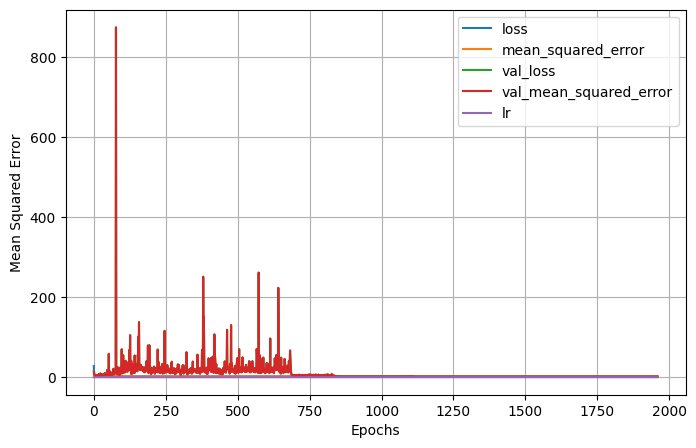

In [21]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Mean Squared Error")
plt.show()

In [22]:
surface_reconstruction_model.save_weights('./Models/surface_reconstruction')

In [20]:
print(results)

           loss  mean_squared_error   val_loss  val_mean_squared_error  \
0     27.919123            8.649260  16.469601               13.416451   
1      6.402214            3.626061  11.958735                9.788376   
2      5.222330            3.201991   7.560665                5.795535   
3      4.475223            2.925454   5.621916                4.185954   
4      3.992495            2.718521   5.699707                4.598703   
...         ...                 ...        ...                     ...   
1955   1.676005            1.669049   1.588753                1.581797   
1956   1.678784            1.671828   1.588753                1.581797   
1957   1.675341            1.668386   1.588741                1.581785   
1958   1.678713            1.671757   1.588759                1.581803   
1959   1.677690            1.670734   1.588754                1.581798   

                lr  
0     1.000000e-02  
1     1.000000e-02  
2     1.000000e-02  
3     1.000000e-02  
4     